In [1]:
!pip uninstall -y ia-packages-synthesis
!pip install --no-cache-dir --force-reinstall git+https://github.com/zaurdar/IA_packages-synthesis.git

Found existing installation: ia-packages-synthesis 0.1.0
Uninstalling ia-packages-synthesis-0.1.0:
  Successfully uninstalled ia-packages-synthesis-0.1.0
  Cloning https://github.com/zaurdar/IA_packages-synthesis.git to c:\users\hugom\appdata\local\temp\pip-req-build-2cgwvqmj
  Resolved https://github.com/zaurdar/IA_packages-synthesis.git to commit 868fd7804bc9af212645dd9dd7eef53ea9747bfc
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/12.6 MB 10.1 MB/s eta 0:00:02
   ------------- -------------------------- 4.2/12.6 MB 10.5 MB/s eta 0:00:01
   ------------------- -------------------- 6.3/12.6

  Running command git clone --filter=blob:none --quiet https://github.com/zaurdar/IA_packages-synthesis.git 'C:\Users\hugom\AppData\Local\Temp\pip-req-build-2cgwvqmj'

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader,Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from ia_packages_synthesis import *
import pandas as pd
from datetime import datetime
from datetime import timedelta
import copy
from scipy.spatial.distance import cosine

In [167]:
file_path = ".\data\database.xlsx"
df = pd.read_excel(file_path,'Feuil3')
Cmd = df.to_numpy()

file_conso_path = ".\data\THHeating.xlsx"
cg = pd.read_excel(file_conso_path)
cg = cg.to_numpy()

file_conso_path = ".\data\TH.xlsx"
cw = pd.read_excel(file_conso_path)
cw = cw.to_numpy()


file_conso_path = ".\data\ThForElec.xlsx"
ce = pd.read_excel(file_conso_path)
ce = ce.to_numpy()

C:\Users\hugom\OneDrive\Documents\Sensorea_AI\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\hugom\OneDrive\Documents\Sensorea_AI\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\hugom\OneDrive\Documents\Sensorea_AI\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# transformation et fusion des dataframe

In [168]:

for i in range(len(cw)):
    cw[i][0] = datetime.strftime(cw[i][0],"%d/%m/%Y %H:%M:%S")

for i in range(len(cg)):
    cg[i][0] = datetime.strftime(cg[i][0],"%d/%m/%Y %H:%M:%S")

for i in range(len(ce)):
    ce[i][0] = datetime.strftime(ce[i][0],"%d/%m/%Y %H:%M:%S")

In [169]:
start_time = datetime.strptime(Cmd[-1][0], "%d/%m/%Y %H:%M:%S")
stop_time = datetime.strptime(Cmd[0][0], "%d/%m/%Y %H:%M:%S")
print(start_time)
print(stop_time)
Ps = timedelta(days=0, hours=0, minutes=15, seconds=0)

2025-08-15 19:20:23
2025-08-18 23:59:54


In [170]:
def sampling(data,start_time,stop_time,Ps):
    dates = copy.deepcopy(data[:,0])
    for i in range(len(dates)):
        dates[i] = datetime.strptime(dates[i], "%d/%m/%Y %H:%M:%S")
    dt = stop_time - start_time
    X = [[start_time+i*Ps] for i in range(int(dt/Ps))]
    for i in range(len(X)):
        k,_ = min(enumerate(dates), key=lambda x:abs(x[1]-X[i][0]))
        X[i].extend(data[k][1:])
    return np.array(X)
Cmd = sampling(Cmd,start_time,stop_time,Ps)
cw = sampling(cw,start_time,stop_time,Ps)
cg = sampling(cg,start_time,stop_time,Ps)
ce = sampling(ce,start_time,stop_time,Ps)

[[0.0 50.1000022888184 0.0 ... 64.8099975585938 64.7300033569336 0.0]
 [0.0 50.1000022888184 0.0 ... 0.0 0.0 0.0]
 [0.0 50.1000022888184 0.0 ... 64.8099975585938 0.0 0.0]
 ...
 [50.120002746582 0.0 69.9499969482422 ... 0.0 0.0 0.0]
 [50.120002746582 0.0 69.9499969482422 ... 0.0 0.0 0.0]
 [50.120002746582 0.0 69.9499969482422 ... 0.0 0.0 0.0]]


In [171]:
Cmd[:,1:] = Cmd[:,1:]/100


# definition des fonction des pipelines

In [172]:
dataframe = []
for i in range(len(Cmd)):
    frame = []
    frame.extend(Cmd[i])
    frame.append(cw[i][1])
    frame.append(ce[i][1])
    frame.append(cg[i][2])
    dataframe.append(frame)
dataframe = np.array(dataframe)
print(dataframe.shape)

(306, 13)


In [173]:
def windowing(dataframe,window_size):
    output = []
    for i in range(0,len(dataframe)-window_size,1):
        output.append(dataframe[i:i+window_size])
    return np.array(output)
def datetime_to_sin(dataframe):
    tempframe = copy.deepcopy(dataframe).tolist()
    for i in range(len(dataframe)):
        hour   = tempframe[i][0].hour
        day_of_year = tempframe[i][0].timetuple().tm_yday
        theta_hour = 2*np.pi*(hour/24)
        theta_day = 2*np.pi*(day_of_year/365)
        tempframe[i] = tempframe[i][1:]
        tempframe[i].append(float(np.sin(theta_hour)))
        tempframe[i].append(float(np.cos(theta_hour)))
        tempframe[i].append(float(np.sin(theta_day)))
        tempframe[i].append(float(np.cos(theta_day)))
    return np.array(tempframe)


In [174]:
def sim(dataframe,W,threshold):
    targets = []
    tempframe = copy.deepcopy(dataframe)
    for i in range(len(dataframe)):
        cos_sim = [cosine(x[-1][12:]*W,tempframe[i][-1][12:]*W) for x in tempframe]
        target = tempframe[i][-1]
        for j in range(len(cos_sim)):
            if cos_sim[j] < threshold:
                if tempframe[j][-1][11]<=target[11]:
                    target = tempframe[j][-1]
        targets.append(target[:9])
    return np.array(targets)


# création pipeline

In [183]:
Inputs_pipeline = preprocessing_pipeline()
Inputs_pipeline.join(datetime_to_sin,"father","datetime_to_sin",{})
Inputs_pipeline.join(windowing,"datetime_to_sin","windowing",{"window_size":20})
Inputs_pipeline.rendering(dataframe)
pipe = Inputs_pipeline.fit()
Inputs_pipeline.save("C:/Users\hugom\OneDrive\Documents\Sensorea_AI\X_pipeline")
X = torch.tensor(pipe(dataframe)).float()

└── [0──node : father────────────────────────────────
├── [1──node : datetime_to_sin──input_shape : [(306, 13)]──output_shape : [(306, 16)]
├── [2──node : windowing──input_shape : [(306, 16)]──output_shape : [(286, 20, 16)]


In [184]:
output_pipeline = preprocessing_pipeline()
output_pipeline.join(datetime_to_sin,"father","datetime_to_sin",{})
output_pipeline.join(windowing,"datetime_to_sin","windowing",{"window_size":20})
output_pipeline.join(sim,"windowing","sim_search",{"W":np.array([0.25,0.25,0.25,0.25]),"threshold":0.1})
output_pipeline.rendering(dataframe)
pipe = output_pipeline.fit()
output_pipeline.save("C:/Users\hugom\OneDrive\Documents\Sensorea_AI\y_pipeline")
y = torch.tensor(pipe(dataframe)).float()

└── [0──node : father────────────────────────────────
├── [1──node : datetime_to_sin──input_shape : [(306, 13)]──output_shape : [(306, 16)]
├── [2──node : windowing──input_shape : [(306, 16)]──output_shape : [(286, 20, 16)]
├── [3──node : sim_search──input_shape : [(286, 20, 16)]──output_shape : [(286, 9)]


# entrainement

## LSTM

In [185]:
class LSTM(nn.Module):
    def __init__(self,in_channels,out_channels,hidden=[128,64]):
        super(LSTM, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels,hidden[0]),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(hidden[0],hidden[1],batch_first=True)
        self.head = nn.Sequential(nn.Linear(hidden[1],out_channels),
                                  nn.Sigmoid())
    def forward(self, x):
        x = self.mlp(x)
        x, (h_n, c_n) = self.lstm(x)
        x = x[:,-1,:]
        x = self.head(x)
        return x
model = LSTM(16,9)
optimizer  = optim.Adam(model.parameters(), lr=0.5e-4)
criterion = nn.MSELoss()

In [204]:
compiler_LSTM = pytorch_compiler(model,optimizer, criterion,40,32)

In [207]:
model,train_losses,val_losses = compiler_LSTM.fit(X,y)

├── nombre de fichiers d'entrainement : 228
├── nombre de fichiers de test : 58


training: 100%|██████████| 40/40 [00:01<00:00, 25.79it/s, train_loss=0.0249, val_loss=0.0289]


$$
\mathrm{MSE}
= \frac{1}{N\,D}
\sum_{n=1}^{N}
\sum_{d=1}^{D}
\left(\hat{y}_{n,d} - y_{n,d}\right)^2
$$



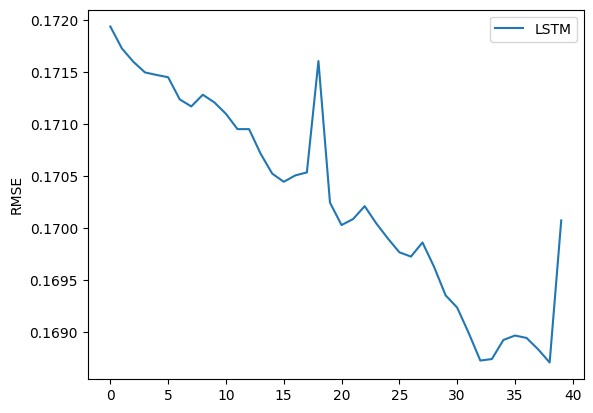

In [210]:
x = [i for i in range(len(train_losses))]
LSTM_RMSE = np.sqrt(val_losses)
plt.plot(x,LSTM_RMSE,label="LSTM")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [201]:
def predict(model,x):
    x = x.unsqueeze(0)
    y_pred = model(x)
    return y_pred
print(predict(model,X[0]))

tensor([[0.4839, 0.1062, 0.7039, 0.0772, 0.6800, 0.1078, 0.6264, 0.2651, 0.1816]],
       grad_fn=<SigmoidBackward0>)
